In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

### Exercise 1 - improving on 2.2 test loss from Andrej Karpathy's video



In [55]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}




### Create the training, dev, and test splits

In [56]:
def tensor_production(data, block_size = 3):

    X = []
    Y = []

    for word in data:

        context = [0] * block_size

        for char in word + '.':


            X.append(context)
            Y.append(stoi[char])

            context = context[1:] + [stoi[char]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


In [57]:
random.seed(42)
random.shuffle(words)

train_limit = int(0.80 * len(words))
test_limit = int(0.90 * len(words))

train_data= words[:train_limit]
dev_data = words[train_limit:test_limit]
test_data = words[test_limit:]

Xtr, Ytr = tensor_production(train_data, block_size = 4)
Xdev, Ydev = tensor_production(dev_data, block_size = 4)
Xtest, Ytest = tensor_production(test_data, block_size = 4)

In [58]:
Xtr

tensor([[ 0,  0,  0,  0],
        [ 0,  0,  0, 25],
        [ 0,  0, 25, 21],
        ...,
        [ 8, 15, 12,  4],
        [15, 12,  4,  1],
        [12,  4,  1, 14]])

In [59]:
Xdev.shape

torch.Size([22655, 4])

In [60]:
Xtest.shape

torch.Size([22866, 4])

### Now set up the dimensions of the layers

In [61]:
def training_parameters(embedding_dim = 10, block_size = 5, layer1_dim = 100):

    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((len(stoi.keys()), embedding_dim))
    W1 = torch.randn((block_size*embedding_dim, layer1_dim))
    b1 = torch.randn(layer1_dim)
    W2 = torch.randn((layer1_dim, 27))
    b2 = torch.randn(27)

    parameters = [C,W1, b1, W2, b2]

    for p in parameters:
        p.requires_grad = True

    return parameters

### Lets define the training loop 

In [ ]:
def training_loop(X_submit,
                Y_submit,
                batch_size,
                iterations,
                parameters,
                discover_learning_rate = False,
                show_loss_steps = False,
                learning_rate_submit = 0.1):

    if discover_learning_rate and not learning_rate_submit:
        learning_rate_range = torch.linspace(-3, 0, iterations)

        lri = 10**learning_rate_range
    else:
        assert learning_rate_submit is not None, "Running model without learning check again!"



    store_lr_perf = []
    store_loss = []
    steps = []

    for it in range(iterations):

        batch = torch.randint(0, X_submit.shape[0], (batch_size,), generator = g)

        embedding = C[X_submit[batch]]

        tanh = torch.tanh(embedding.view(-1,W1.shape[0]) @ W1 + b1)

        logits = tanh@W2 + b2 

        loss = F.cross_entropy(logits, Y_submit[batch])


        #We need to reset the gradients before we run backward so that we don't compile grads
        for p in parameters:
            p.grad = None

        store_loss.append(loss.item())
        steps.append(it)

        loss.backward()

        if discover_learning_rate and not learning_rate_submit:
            learning_rate = lri[it]
            store_lr_perf.append(learning_rate)
        else:
            learning_rate = learning_rate_submit

        #Now update the parameters
        for p in parameters:
            p.data += -learning_rate * p.grad


    
    print(f"Training Loss: {loss.item()}")

    if discover_learning_rate and not learning_rate_submit:
        print(f"Learning Rate storage shape{len(store_lr_perf)}")
        print(f"Loss storage shape{len(store_loss)}")  
        plt.title("Loss per learning rate")
        plt.plot(store_lr_perf, store_loss)

        if show_loss_steps:
            plt.clf()

        


    if show_loss_steps:
        plt.title("Loss per step")
        plt.plot(steps, store_loss)


    
    


In [76]:
parameters = training_parameters(embedding_dim = 20,
                    block_size = 4,
                    layer1_dim = 300)


C  =  parameters[0]
W1 = parameters[1]
b1 = parameters[2]
W2 = parameters[3]
b2 = parameters[4]

In [77]:
C.shape

torch.Size([27, 20])

In [78]:
W1.shape, b1.shape



(torch.Size([80, 300]), torch.Size([300]))

In [79]:
W2.shape, b2.shape

(torch.Size([300, 27]), torch.Size([27]))

Training Loss: 2.235743284225464


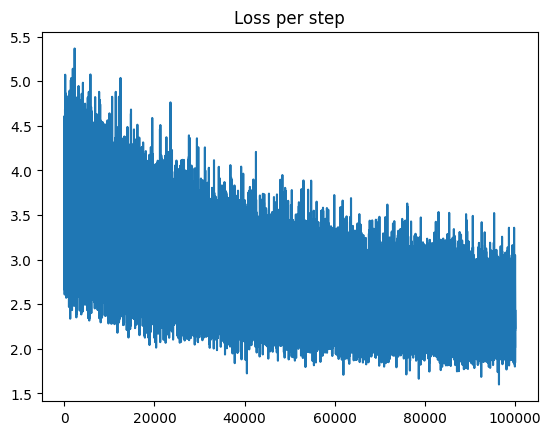

In [83]:
training_loop(X_submit = Xtr,
            Y_submit = Ytr,
            batch_size = 100,
            iterations = 100000,
            parameters = parameters,
            discover_learning_rate=False,
            show_loss_steps=True,
            learning_rate_submit = 0.01)

In [ ]:
#We can see learning rate is working best when aroudn ~0.1

#### now lets run on dev set


In [84]:

embedding = C[Xdev]
tanh = torch.tanh(embedding.view(-1,W1.shape[0]) @ W1 + b1)

logits = tanh@W2 + b2 

loss_dev = F.cross_entropy(logits, Ydev)

print(f"Loss in dev {loss_dev}")

Loss in dev 2.509866237640381


In [85]:
embedding = C[Xtest]
tanh = torch.tanh(embedding.view(-1,W1.shape[0]) @ W1 + b1)

logits = tanh@W2 + b2 

loss_test = F.cross_entropy(logits, Ytest)

print(f"Loss in dev {loss_test}")

Loss in dev 2.511065721511841


In [100]:
block_size = 4
g = torch.Generator().manual_seed(2147483647) #be sure to keep the generator outside of the loop!
for _ in range(20):

    out = []

    context = [0] * block_size


    while True:
        
        embeddings = C[torch.tensor([context])]

        layer1 = torch.tanh(embeddings.view(1, -1) @ W1  + b1)

        logits = layer1@W2 + b2

        probabilities = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probabilities,
                                num_samples = 1,
                                generator = g,
                                replacement = False).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==  0:
            break
        
    print(''.join(itos[char_i] for char_i in out))

junid.
diana.
azoph.
fayleigh.
kaitrith.
sabrahel.
kalania.
yamilen.
asptyneida.
irellinoriean.
arterin.
munterf.
demmer.
finshian.
jazl.
core.
yaen.
caryesari.
westelin.
wynik.
